I'll be building a cnn for multiclass classification using the `TINYVGG` architechture

In [121]:
# Importing dependencies
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [ ]:
# Getting the data
train_data = datasets.MNIST(root="data", train=True, transform=ToTensor(), target_transform=None)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


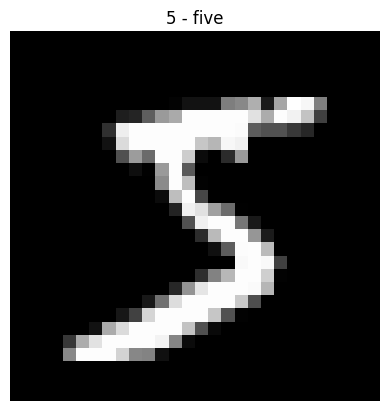

In [3]:
# Lets take a look at the data
print(test_data.classes) # we got 10 classes
class_names = test_data.classes
X,y = train_data[0]
plt.imshow(X.squeeze(), cmap="gray")
plt.title(class_names[y]);
plt.axis(False)
acc_fn = Accuracy(task="multiclass", num_classes= len(class_names))

In [4]:
# Load the data into a dataloader for bacthing
BATCH_SIZE =32
train_dataloader = DataLoader(train_data,BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [5]:
len(train_dataloader)

1875

In [160]:
# Make the training and testing functions for convenience
def train_loop(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optim:torch.optim.Optimizer,
               acc_fn):
    model.train()
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X) # model outputs logits ggff
        loss = loss_fn(pred, y) # cross entropy makes use of the logits so we dont have to convert to prediction probabilities
        train_loss += loss
        train_acc += acc_fn(pred.argmax(dim=1), y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    # Calculate loss and accuracy per epoch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f} ")

def test_loop(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               acc_fn):
    test_loss , test_acc =0,0
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += acc_fn(pred.argmax(dim=1), y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}")

def get_model_results(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               acc_fn):
    test_loss , test_acc =0,0
    model.eval()
    pred_prob=[]
    with torch.inference_mode():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += acc_fn(pred.argmax(dim=1), y)
            pred_prob.append(pred.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}")
    return pred_prob


In [124]:
#Currently using the TINYVGG cnn architechture
class MNISTMODEL(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,2,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units,2,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )
    def forward(self, x):
        x= self.conv_block_1(x)
        #print(x.shape)
        x= self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

model = MNISTMODEL(input_shape=1, hidden_units=16, output_shape=len(class_names))

In [125]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [126]:
# I'm going get get a smaller tensor to test out the model
X,y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [127]:
# Passing it through the model
model(X)
# Encountered some errors before but i have modified the class to get the correct input shape

tensor([[-0.0265, -0.0245,  0.0217, -0.0134,  0.0128, -0.0445, -0.0192, -0.0178,
         -0.0036, -0.0192],
        [-0.0273, -0.0257,  0.0182, -0.0079,  0.0218, -0.0449, -0.0165, -0.0175,
          0.0028, -0.0174],
        [-0.0207, -0.0273,  0.0136, -0.0095,  0.0170, -0.0413, -0.0133, -0.0180,
          0.0052, -0.0090],
        [-0.0211, -0.0282,  0.0149, -0.0070,  0.0126, -0.0387, -0.0135, -0.0224,
          0.0034, -0.0067],
        [-0.0221, -0.0355,  0.0135, -0.0007,  0.0126, -0.0439, -0.0135, -0.0180,
          0.0097, -0.0110],
        [-0.0268, -0.0247,  0.0099, -0.0138,  0.0124, -0.0417, -0.0170, -0.0125,
          0.0114, -0.0175],
        [-0.0242, -0.0197,  0.0159, -0.0102,  0.0163, -0.0478, -0.0117, -0.0203,
          0.0068, -0.0157],
        [-0.0338, -0.0261,  0.0106, -0.0087,  0.0169, -0.0429, -0.0165, -0.0187,
          0.0076, -0.0131],
        [-0.0229, -0.0304,  0.0148, -0.0029,  0.0160, -0.0405, -0.0113, -0.0178,
          0.0062, -0.0099],
        [-0.0316, -

In [128]:
# I want to make a function to calculate the training time of the model
def train_time(start:float, end:float, device="cpu"):
    total_time = end - start
    print(f"Training time on {device}: {total_time}")
    return total_time

In [129]:
# Train the model
epochs = 3
start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_loop(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optim=optim,acc_fn=acc_fn)
    test_loop(model=model, dataloader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn)
end = timer()
train_time(start=start, end=end)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 0.25757 | Train accuracy: 91.71 
Test loss: 0.06276 | Test accuracy: 98.02
Epoch: 1
-----------
Train loss: 0.07116 | Train accuracy: 97.82 
Test loss: 0.05255 | Test accuracy: 98.44
Epoch: 2
-----------
Train loss: 0.05454 | Train accuracy: 98.27 
Test loss: 0.05770 | Test accuracy: 98.09
Training time on cpu: 343.51750719999836


343.51750719999836

In [206]:
preds = get_model_results(model=model, dataloader=test_dataloader, loss_fn=loss_fn,acc_fn=acc_fn)

pred = []
for ten in preds:
    for tenr in ten:
        pred.append(tenr.item())

label = []
feature = []
for X,y in list(test_data):
    label.append(y)
    feature.append(X)

Test loss: 0.05770 | Test accuracy: 98.09


In [207]:
feature = torch.stack(feature)

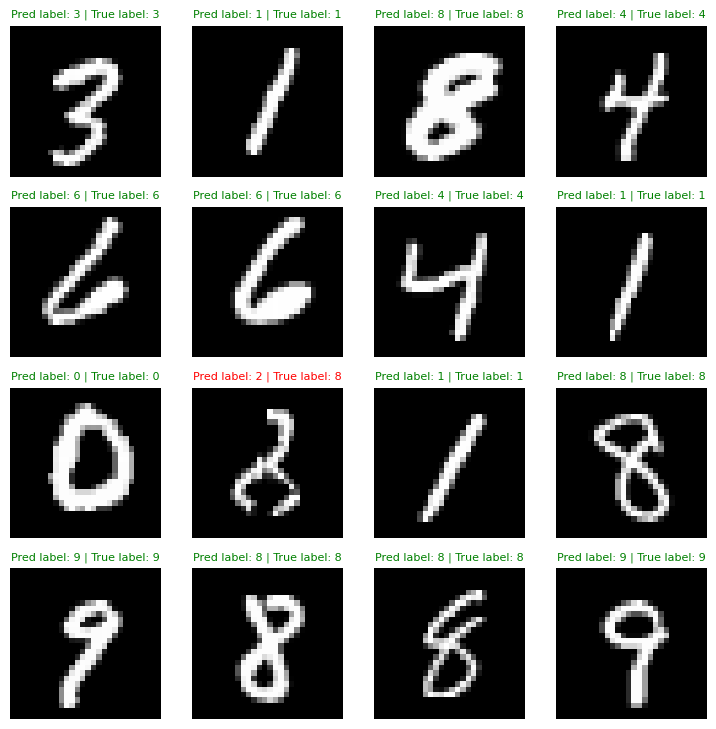

In [208]:
# I'm going to make a plt figure showing the predictions
NROWS = 4
NCOLS = 4
fig = plt.figure(figsize=(9,9))
for num in range(1, NROWS*NCOLS+1):
    no = random.randint(0, len(feature))
    img = feature[no].squeeze()
    true_label = label[no]
    pred_label = pred[no]
    fig.add_subplot(NROWS,NCOLS,num)
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    title_text = f"Pred label: {pred_label} | True label: {true_label}"
    if pred_label == true_label:
        plt.title(title_text, fontsize=8, c="g")
    else:
        plt.title(title_text, fontsize=8, c="r")
    

I'd say its a fairly good model since its rare to encounter wrong predictions unless the image itself isn't descriptive enough